In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import sys
# np.set_printoptions(threshold=sys.maxsize)


In [4]:
def show(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [5]:
def maxSize(lst):
    size = []
    for arr in lst:
        x,y,z = arr.shape
        size.append(x)
    maxpos = size.index(max(size))
    return(lst[maxpos])

In [8]:
def getROI(input_path , output_path):
    img_original = cv2.imread(input_path)
    h, w,_ = img_original.shape
    img0 = np.zeros((h+160,w,3), np.uint8)
    img0[80:-80,:] = img_original
    img = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.GaussianBlur(img,(5,5),0)
    _, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    
    M = cv2.moments(th)
    h, w = img.shape
    x_c = M['m10'] // M['m00']
    y_c = M['m01'] // M['m00']

    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]]).astype(np.uint8)
    erosion = cv2.erode(th,kernel,iterations=1)
    boundary = th - erosion
    __, cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    cnt = maxSize(cnt)


    img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)

    cnt = cnt.reshape(-1,2)

    left_id = np.argmin(cnt.sum(-1))

    cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])
    
    dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
    f = np.fft.rfft(dist_c)
    cutoff = 15
    f_new = np.concatenate([f[:cutoff],0*f[cutoff:]])
    dist_c_1 = np.fft.irfft(f_new)
    
    derivative = np.diff(dist_c_1)
    sign_change = np.diff(np.sign(derivative))/2
    
    minimas = cnt[np.where(sign_change>0)[0]]
#     print(minimas)

    v1, v2 = minimas[-2], minimas[-4]
    
    theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
#     print('The rotation of ROI is {:.02f}\u00b0'.format(theta))

    
    #*****************
    if(theta > 33):
        v1, v2 = minimas[-1], minimas[-3]
        
        theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi    
#         print('The rotation of ROI is {:.02f}\u00b0'.format(theta))

    #*****************





    R = cv2.getRotationMatrix2D(tuple(v2),theta,1)
    img_r = cv2.warpAffine(img0,R,(w,h))
    v1 = (R[:,:2] @ v1 + R[:,-1]).astype(np.int)
    v2 = (R[:,:2] @ v2 + R[:,-1]).astype(np.int)

    ux = v1[0]
    uy = v1[1] + (v2-v1)[0]//3
    lx = v2[0]
    ly = v2[1] + 4*(v2-v1)[0]//3

    roi = img_r[uy:ly,ux:lx]
    plt.figure(figsize=(5,5))
    show(roi)
    cv2.imwrite(output_path,roi)

1 :
2 :
3 :
4 :
5 :
6 :
7 :
8 :
9 :


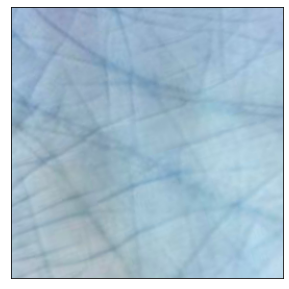

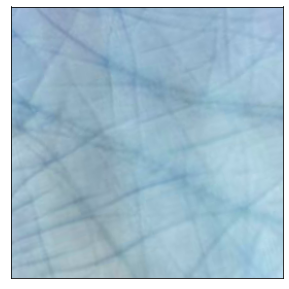

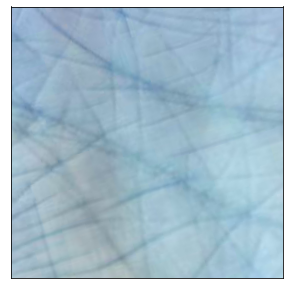

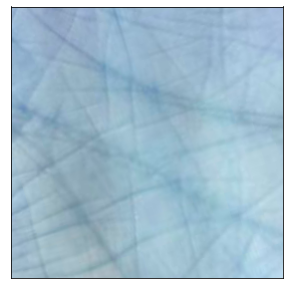

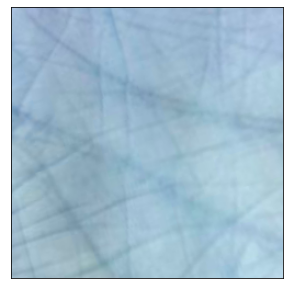

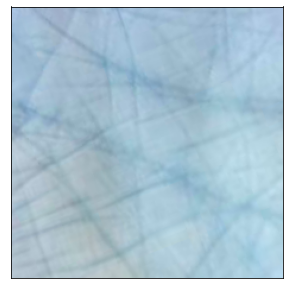

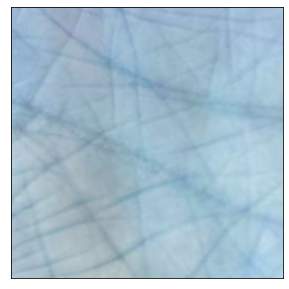

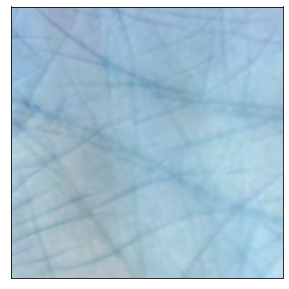

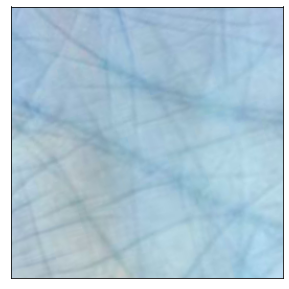

In [11]:
for i in range(1,10):
    print(i,':')
    inp = './images/original/tommy/test' + str(i) + '.jpg'
    outp = './images/roi/tommy/test' + str(i) + '.jpg'
    getROI(inp,outp)



1 :
2 :


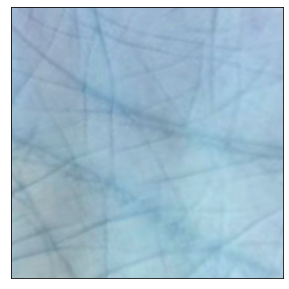

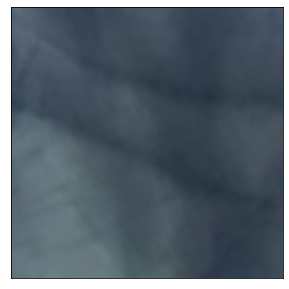

In [10]:
for i in range(1,3):
    print(i,':')
    inp = './images/original/tommy/tommy' + str(i) + '.jpg'
    outp = './images/roi/tommy/tommy' + str(i) + '.jpg'
    getROI(inp,outp)


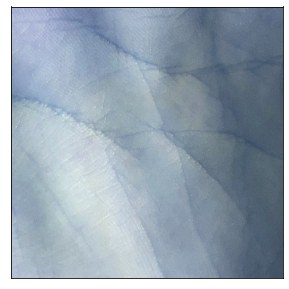

In [9]:
inp = './images/original/eddy/eddy1.jpg'
outp = './images/roi/eddy/eddy1.jpg'
getROI(inp,outp)
